In [692]:
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from time import time

In [693]:
#plotting tools

In [694]:
def makePlotOnlyData(data):
    x = []
    y = []
    
    for i in range(0,len(data), 1):
        x.append(data[i][0]['x1'])
        y.append(data[i][0]['x2'])  
    
    plt.figure(figsize=(10,5))
    plt.scatter(x,y)
    plt.xlabel('x1')
    plt.ylabel('x2')    

In [695]:
def makePlotWithColors(data):
    x = []
    y = []
    colors = []
    for i in range(0,len(data), 1):
        x.append(data[i][0]['x1'])
        y.append(data[i][0]['x2'])  
        colors.append(data[i][1].index(max(data[i][1])))
    plt.figure(figsize=(10,5))
    plt.scatter(x,y, c=colors)
    plt.xlabel('x1')
    plt.ylabel('x2')    
    

In [696]:
#soft k means algorithm

In [697]:
def soft_k_means_beta_threshold(data, c, init_t, threshold, sigma, alpha, beta_threshold):
    
    beta = 1/init_t
    centers = initialize_center(len(data))
    data = reassign_clusters(centers, data, beta)
    centers = bayes_rule(data, centers)
    initialization = True
    
    while(beta < beta_threshold):
        initialization = False
        data, centers = split(data, centers, sigma)    
        orig_centers = copy.deepcopy(centers)
        
        data = reassign_clusters(centers, data, beta)
        
        centers = bayes_rule(data, centers)
        centers = calculate_center_points(data, centers)
        #makePlotNoLabel(data, centers)
        
        while(still_converging(orig_centers, centers, threshold)):
            orig_centers = copy.deepcopy(centers)
            
            data = reassign_clusters(centers, data, beta)
            centers = bayes_rule(data, centers)
            centers = calculate_center_points(data, centers)
  
        data, centers = merge(data, centers, alpha)

        init_t = init_t / c
        beta = 1 / init_t
    print([beta, len(centers)])
    return data, centers
    
    

In [698]:
def soft_k_means_deterministic(data, c, init_t, threshold, sigma, alpha):
    
    beta = 1/init_t
    data, centers = initialize(data, len(data))
    data = reassign_clusters(centers, data, beta)
    centers = bayes_rule(data, centers)
    initialization = True
    
    while(is_not_deterministic(data, initialization)):
        initialization = False
        data, centers = split(data, centers, sigma)    
        orig_centers = copy.deepcopy(centers)
        
        data = reassign_clusters(centers, data, beta)
        centers = bayes_rule(data, centers)
        centers = calculate_center_points(data, centers)
        while(still_converging(orig_centers, centers, threshold)):
            orig_centers = copy.deepcopy(centers)
            
            data = reassign_clusters(centers, data, beta)
            centers = bayes_rule(data, centers)
            centers = calculate_center_points(data, centers)

        data, centers = merge(data, centers, alpha)
        data = reassign_clusters(centers, data, beta)
        
        init_t = init_t / c
        beta = 1 / init_t
    #print([beta, len(centers)])
    return data, centers
    
    

In [699]:
def split(data, centers, sigma):

    centers = centers + copy.deepcopy(centers)
    halfway = math.floor(len(centers)/2)
    data = add_clusters_to_data(data)
    for k in range(halfway, len(centers), 1):
        centers[k][0]['x1'] = centers[k-halfway][0]['x1'] + random.uniform(-sigma, sigma)
        centers[k][0]['x2'] = centers[k-halfway][0]['x2'] + random.uniform(-sigma, sigma)    
        
    return data, centers



def merge(data, centers, alpha):
    newCenters = []
    newCentersIndex = []
    halfway = math.floor(len(centers)/2)
    for p in range(halfway, len(centers), 1):
        duplicate = False
        for k in range(0, halfway, 1):
            if (too_close(centers[k][0], centers[p][0], alpha)):                
                duplicate = True
                break
        if(not duplicate):
            newCenters.append(centers[p])
            newCentersIndex.append(p)
     
    centers = centers[0:halfway] + newCenters
    
    data = remove_clusters_from_data(data, halfway, newCentersIndex)
    
    return data, centers


def too_close(x1, x2, threshold):
    x1Diff = abs(x1['x1'] - x2['x1'])
    x2Diff = abs(x1['x2'] - x2['x2'])
    
    if(x1Diff < threshold and x2Diff < threshold):

        return True
    
    return False

In [700]:
def add_clusters_to_data(data):
    for n in range(0, len(data), 1):
        dup = copy.deepcopy(data[n][1])
        data[n][1] = data[n][1] + dup
    return data


def remove_clusters_from_data(data, numbCenters, centerIndexes):
    
    for n in range(0, len(data), 1):
        merged_data = data[n][1][:numbCenters]
        for k in centerIndexes:
            merged_data.append(data[n][1][k])
        data[n][1] = merged_data
    return data

In [701]:
def still_converging(orig_centers, updated_centers, threshold):
    moved = False
    for k in range(0, len(orig_centers), 1):
        x1Diff = abs(orig_centers[k][0]['x1'] - updated_centers[k][0]['x1'])
        x2Diff = abs(orig_centers[k][0]['x2'] - updated_centers[k][0]['x2'])
        
        if(x1Diff > threshold or x2Diff > threshold):
            moved = True
            break
    return moved

In [702]:
def is_not_deterministic(data, initialization):
    if(initialization):
        return True
    value = 2
    maxVal = 0
    for n in range(0, len(data), 1):
        maxVal = max(data[n][1])
        value = min(value, maxVal)

    if(value < 0.9999):
        return True
    return False

In [703]:
def initialize(data, numb_data_points):
    centers_data = []
    position = {'x1': 0, 'x2': 0}
    probabilty_cluster_contains_point = []
        
    for k in range(0, numb_data_points, 1):
        probabilty_cluster_contains_point.append( (1/numb_data_points) )
        
    centers_data.append([position, probabilty_cluster_contains_point])
    for n in range(0, len(data), 1):
        data[n][1] = []
        data[n][1].append(1)
    return data, centers_data
       

In [704]:
def calculate_center_points(data, centers):
    for k in range(0,len(centers),1):
        avg_x = 0;
        avg_y = 0;
        
        for n in range(0, len(data), 1):
            avg_x += centers[k][1][n]* data[n][0]['x1']
            avg_y += centers[k][1][n]* data[n][0]['x2']
            
        centers[k][0]['x1'] = avg_x
        centers[k][0]['x2'] = avg_y
    return centers

In [705]:
def bayes_rule(data, centers):
    for k in range(0, len(centers), 1):
        for n in range(0, len(data), 1):
            p_c_given_x = data[n][1][k]
            sum_p_c_given_x = 0
            
            for n2 in range(0, len(data), 1):
                sum_p_c_given_x += data[n2][1][k]
            if(sum_p_c_given_x == 0):
                centers[k][1][n] = 0
            else:
                centers[k][1][n] = p_c_given_x / sum_p_c_given_x
            
    return centers

In [706]:
def reassign_clusters(clusters, data, beta):
    for n in range(0, len(data), 1):
        z = 0 
        for k in range(0, len(clusters), 1):
            p_c = calculate_p_c(data, k)
            z = calculate_z(data, data[n], clusters, beta)
            if(z==0):
                p_c_given_x = 0
            else:    
                p_c_given_x = (p_c / z) *  math.exp( -beta * distance(data[n][0], clusters[k][0]) )
            data[n][1][k] = p_c_given_x
            
    return data    

In [707]:
def distance(data_position, center_position):
 
    x1_dist = (data_position['x1'] - center_position['x1'])**2
    x2_dist = (data_position['x2'] - center_position['x2'])**2
    
    return (1/2) * (x1_dist + x2_dist)

In [708]:
def calculate_p_c(data, k):
    p_c = 0
    for x in range(0, len(data), 1):
        p_c += data[x][1][k] 
    return p_c / len(data)

In [709]:
def calculate_z(data, data_point, clusters, beta):
    z = 0
    for c in range(0, len(clusters), 1):
        z += ( calculate_p_c(data, c)*math.exp( -beta * distance(data_point[0], clusters[c][0])) )
    return z
    

In [710]:
# make data

In [711]:
def make_data(clusters, points_per_cluster, xBoundary, yBoundary, sigma):
    data = []
    for i in range(0, clusters, 1):
        xcenter = np.random.randint(-xBoundary , xBoundary,1)[0]
        ycenter = np.random.randint(-yBoundary , yBoundary,1)[0]
        
        for j in range(0, points_per_cluster, 1):
            position = {'x1': np.random.normal(xcenter, sigma), 
                        'x2': np.random.normal(ycenter, sigma)}
            proability_point_in_cluster = [1/clusters]
            
            data.append([position, proability_point_in_cluster])
    return data

In [712]:
def make_data_2(clusters, points_per_cluster, xBoundary, yBoundary, max_sigma):
    data = []
    for i in range(0, clusters, 1):
        xcenter = np.random.randint(-xBoundary , xBoundary,1)[0]
        ycenter = np.random.randint(-yBoundary , yBoundary,1)[0]
        sigma = random.uniform(0, max_sigma)
        for j in range(0, points_per_cluster, 1):
            position = {'x1': np.random.normal(xcenter, sigma), 
                        'x2': np.random.normal(ycenter, sigma)}
            proability_point_in_cluster = [1/clusters]
            
            data.append([position, proability_point_in_cluster, i])
    return data

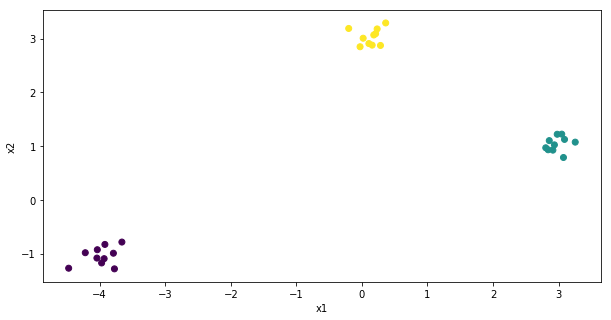

In [714]:
#data = make_data_2(5, 10, 5,5,1)
data = make_data(3, 10, 5,5,0.2)
data2, centers = soft_k_means_deterministic(data, 1.5, 5, 0.3, 0.6, 0.4)
makePlotWithColors(data)